In [1]:
import spacy
import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag, pos_tag_sents
import pandas as pd
import numpy as np
from collections import Counter
from glob import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# The following are optional dependencies. 
# Feel free to comment these out. 
# Sent2tree uses the sent2tree.py module in this repository. 
from sent2tree import sentenceTree
import ete3 
import seaborn

# Display plots in this notebook, instead of externally. 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style()

/Users/spicy.kev/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
defoe_raw = open('defoe.txt').read()
eliot_raw = open('eliot.txt').read()
stoker_raw = open('stoker.txt').read()
kerouac_raw = open('kerouac.txt').read()

In [4]:
defoe = nlp(defoe_raw)
eliot = nlp(eliot_raw)
stoker = nlp(stoker_raw)
kerouac = nlp(kerouac_raw)

In [5]:
kerouacSents = list(kerouac.sents)
kerouacSentenceLengths = [len(sent) for sent in kerouacSents]
sent = [sent for sent in kerouacSents if len(sent) == max(kerouacSentenceLengths)]
sent[0]

Not like driving across Carolina, or Texas, or Arizona, or Illinois; but like driving across the world and into the places where we would finally learn ourselves among the Fellahin Indians of the world, the essential strain of the basic primitive, wailing humanity that stretches in a belt around the equatorial belly of the world from Malaya (the long fingernail of China) to India the great subcontinent to Arabia to Morocco to the selfsame deserts and jungles of Mexico and over the waves to Polynesia to mystic Siam of the Yellow Robe and on around, on around, so that you hear the same mournful wail by the rotted walls of Cadiz, Spain, that you hear 12,000 miles around in the depths of Benares the Capital of the World.

In [6]:
tagDict = {w.pos: w.pos_ for w in kerouac}
tagDict

{85: 'ADP',
 90: 'DET',
 92: 'NOUN',
 103: 'SPACE',
 93: 'NUM',
 95: 'PRON',
 86: 'ADV',
 100: 'VERB',
 96: 'PROPN',
 89: 'CCONJ',
 94: 'PART',
 97: 'PUNCT',
 84: 'ADJ',
 87: 'AUX',
 91: 'INTJ',
 101: 'X',
 99: 'SYM'}

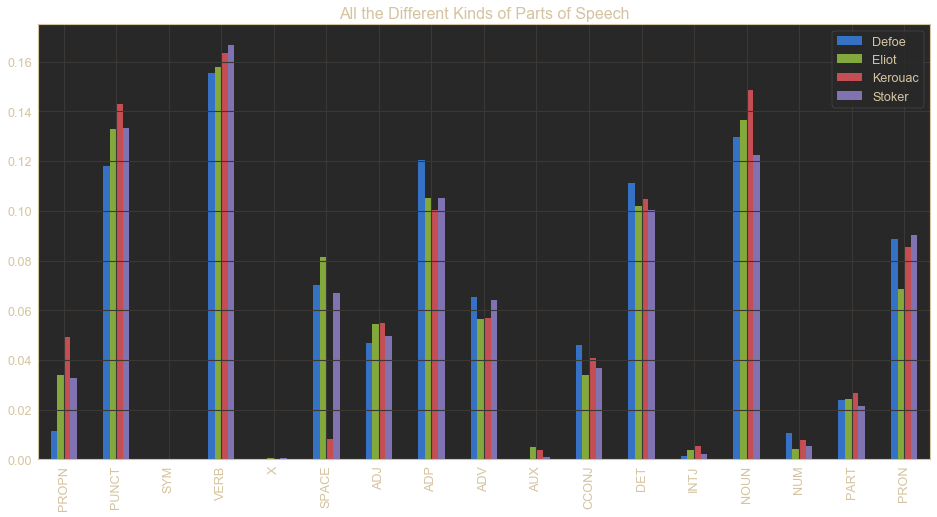

In [7]:
defoePOS = pd.Series(defoe.count_by(spacy.attrs.POS))/len(defoe)
eliotPOS= pd.Series(eliot.count_by(spacy.attrs.POS))/len(eliot)
stokerPOS = pd.Series(stoker.count_by(spacy.attrs.POS))/len(stoker)
kerouacPOS = pd.Series(kerouac.count_by(spacy.attrs.POS))/len(kerouac)

rcParams['figure.figsize'] = 16, 8
df = pd.DataFrame([defoePOS, eliotPOS, kerouacPOS, stokerPOS], index=['Defoe', 'Eliot', 'Kerouac', 'Stoker'])
df.columns = [tagDict[column] for column in df.columns]
df.T.plot(kind='bar')
plt.style.use("dark_background")
plt.title('All the Different Kinds of Parts of Speech', fontsize=16)
plt.savefig("kindsofwords.png")

In [8]:
defoeVerbs = [w for w in defoe if w.pos_ == 'VERB']
Counter([w.string.strip() for w in defoeVerbs]).most_common(10)

[('was', 1972),
 ('had', 1547),
 ('be', 670),
 ('were', 588),
 ('could', 567),
 ('have', 485),
 ('would', 481),
 ('made', 351),
 ('been', 318),
 ('might', 297)]

In [9]:
kerouacVerbs = [w for w in kerouac if w.pos_ == 'VERB']
Counter([w.string.strip() for w in kerouacVerbs]).most_common(10)

[('was', 2046),
 ('had', 766),
 ('were', 576),
 ('said', 548),
 ("'s", 355),
 ('do', 333),
 ('went', 328),
 ('got', 304),
 ('go', 292),
 ('is', 279)]

In [10]:
kerouacProns = [w for w in kerouac if w.pos_ == 'PRON']
Counter([w.string.strip() for w in kerouacProns]).most_common(10)

[('I', 2886),
 ('he', 1136),
 ('it', 926),
 ('we', 850),
 ('you', 799),
 ('me', 626),
 ('We', 565),
 ('He', 563),
 ('him', 482),
 ('they', 341)]

In [11]:
deanMoriartySents = [sent for sent in kerouac.sents if 'Dean Moriarty' in sent.string]
deanMoriartySents

[With the coming of Dean Moriarty began the part of my life you could call my life on the road.,
 At one point Carlo and I talked about the letters and wondered if we would ever meet the strange Dean Moriarty.,
 He came right out to Paterson, New Jersey, where I was living with my aunt, and one night while I was studying there was a knock on the door, and there was Dean, bowing, shuffling obsequiously in the dark of the hall, and saying, "Hello, you remember me-Dean Moriarty?,
 I sensed some kind of conspiracy in the air, and this conspiracy lined up two groups in the gang: it was Chad King and Tim Gray and Roland Major, together with the Rawlinses, generally agreeing to ignore Dean Moriarty and Carlo Marx.,
 It seemed to me every bum on Larimer Street maybe was Dean Moriarty's father; Old Dean Moriarty,
 and I saw the Christmas tree, the presents, and smelled the roasting turkey and listened to the talk of the relatives, but now the bug was on me again, and the bug's name was Dean Mor

In [12]:
dm2 = deanMoriartySents[2]
dm2

He came right out to Paterson, New Jersey, where I was living with my aunt, and one night while I was studying there was a knock on the door, and there was Dean, bowing, shuffling obsequiously in the dark of the hall, and saying, "Hello, you remember me-Dean Moriarty?

In [13]:
for word in dm2:
    print(word,word.tag_, word.pos_)

He PRP PRON
came VBD VERB
right RB ADV
out IN ADP
to IN ADP
Paterson NNP PROPN
, , PUNCT
New NNP PROPN
Jersey NNP PROPN
, , PUNCT
where WRB ADV
I PRP PRON
was VBD VERB
living VBG VERB
with IN ADP
my PRP$ DET
aunt NN NOUN
, , PUNCT
and CC CCONJ
one CD NUM
night NN NOUN
while IN ADP
I PRP PRON
was VBD VERB
studying VBG VERB
there EX ADV
was VBD VERB
a DT DET
knock NN NOUN
on IN ADP
the DT DET
door NN NOUN
, , PUNCT
and CC CCONJ
there EX ADV
was VBD VERB
Dean NNP PROPN
, , PUNCT
bowing VBG VERB
, , PUNCT
shuffling VBG VERB
obsequiously RB ADV
in IN ADP
the DT DET
dark NN NOUN
of IN ADP
the DT DET
hall NN NOUN
, , PUNCT
and CC CCONJ
saying VBG VERB
, , PUNCT
" `` PUNCT
Hello UH INTJ
, , PUNCT
you PRP PRON
remember VBP VERB
me PRP PRON
- HYPH PUNCT
Dean NNP PROPN
Moriarty NNP PROPN
? . PUNCT


In [14]:
[prop for prop in dir(dm2) if not prop.startswith('_')]

['as_doc',
 'conjuncts',
 'doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'ents',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'kb_id',
 'kb_id_',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'lower_',
 'merge',
 'n_lefts',
 'n_rights',
 'noun_chunks',
 'orth_',
 'remove_extension',
 'rights',
 'root',
 'sent',
 'sentiment',
 'set_extension',
 'similarity',
 'start',
 'start_char',
 'string',
 'subtree',
 'text',
 'text_with_ws',
 'to_array',
 'upper_',
 'vector',
 'vector_norm',
 'vocab']

In [15]:
dm2.root

came

In [16]:
list(dm2.root.children)

[He, out, ,, and, was]

In [17]:
for word in dm2:
    print(word, ': ', str(list(word.children)))

He :  []
came :  [He, out, ,, and, was]
right :  []
out :  [right, to]
to :  [Paterson]
Paterson :  [,, Jersey, ,, living]
, :  []
New :  []
Jersey :  [New]
, :  []
where :  []
I :  []
was :  []
living :  [where, I, was, with]
with :  [aunt]
my :  []
aunt :  [my]
, :  []
and :  []
one :  []
night :  [one, studying]
while :  []
I :  []
was :  []
studying :  [while, I, was, there]
there :  []
was :  [night, knock, ,, and, was]
a :  []
knock :  [a, on]
on :  [door]
the :  []
door :  [the]
, :  []
and :  []
there :  []
was :  [there, Dean, ,, bowing, ?]
Dean :  []
, :  []
bowing :  [,, shuffling]
, :  []
shuffling :  [obsequiously, in, ,, and, saying]
obsequiously :  []
in :  [dark]
the :  []
dark :  [the, of]
of :  [hall]
the :  []
hall :  [the]
, :  []
and :  []
saying :  [,, remember]
, :  []
" :  []
Hello :  ["]
, :  []
you :  []
remember :  [Hello, ,, you, Moriarty]
me :  []
- :  []
Dean :  []
Moriarty :  [me, -, Dean]
? :  []


In [18]:
Counter([w.string.strip() for w in kerouac.ents if w.label_ == 'PERSON']).most_common(10)

[('Dean', 779),
 ('Marylou', 134),
 ('Sal', 110),
 ('Remi', 92),
 ('Terry', 78),
 ('Carlo', 58),
 ('Camille', 57),
 ('Stan', 55),
 ('Ed Dunkel', 41),
 ('Lee Ann', 33)]

In [19]:
def adjectivesDescribingCharacters(text, character):
    sents = [sent for sent in kerouac.sents if character in sent.string]
    adjectives = []
    for sent in sents:
        for word in sent:
            if character in word.string:
                for child in word.children:
                    if child.pos_ == 'ADJ':
                        adjectives.append(child.string.strip())
    return Counter(adjectives).most_common(10)
    

In [20]:
adjectivesDescribingCharacters(kerouac, 'Sal')

[('dear', 2),
 ('old', 2),
 ('Poor', 1),
 ('little', 1),
 ('wonderful', 1),
 ('poor', 1)]

In [21]:
adjectivesDescribingCharacters(kerouac, 'Dean')

[('ragged', 2),
 ('old', 2),
 ('only', 1),
 ('new', 1),
 ('blissful', 1),
 ('Poor', 1),
 ('important', 1),
 ('frantic', 1),
 ('poorchild', 1),
 ('crazy', 1)]

In [22]:
adjectivesDescribingCharacters(kerouac, 'Marylou')

[('luscious', 1), ('sweet', 1)]

In [23]:
marylouSentences = [sent for sent in kerouac.sents if 'Marylou' in sent.string]

In [24]:
marylouSentences[6]

while we sat around dumbly smoking butts from ashtrays in the gray light of a gloomy day, Dean got up nervously, paced around, thinking, and decided the thing to do was to have Marylou make breakfast and sweep the floor.

In [25]:
#Defining a function to give us all the verbs used to describe a character
def verbsForCharacters(text, character):
    sents = [sent for sent in kerouac.sents if character in sent.string]
    charWords = []
    for sent in sents: 
        for word in sent: 
            if character in word.string: 
                charWords.append(word)
    charAdjectives = []
    for word in charWords: 
        #This statement will run up the tree until the first verb
        for ancestor in word.ancestors: 
            if ancestor.pos_.startswith('V'): 
                charAdjectives.append(ancestor.lemma_.strip())
    return Counter(charAdjectives).most_common(20)

In [26]:
marylouVerbs = verbsForCharacters(kerouac, 'Marylou')
marylouVerbs

[('be', 34),
 ('have', 10),
 ('want', 10),
 ('know', 9),
 ('go', 9),
 ('say', 8),
 ('sleep', 7),
 ('see', 6),
 ('get', 5),
 ('sit', 5),
 ('make', 5),
 ('take', 5),
 ('tell', 4),
 ('find', 4),
 ('jump', 3),
 ('run', 3),
 ('do', 3),
 ('drive', 3),
 ('wait', 3),
 ('lean', 3)]

In [27]:
deanVerbs = verbsForCharacters(kerouac, 'Dean')
salVerbs = verbsForCharacters(kerouac, 'Sal')
salVerbs

[('be', 25),
 ('go', 18),
 ('say', 14),
 ('get', 10),
 ('tell', 8),
 ('think', 8),
 ('have', 7),
 ('want', 5),
 ('know', 4),
 ('come', 4),
 ('dig', 4),
 ('do', 3),
 ('call', 3),
 ('let', 3),
 ('make', 3),
 ('see', 3),
 ('ask', 2),
 ('arrive', 2),
 ('remember', 2),
 ('find', 2)]

In [28]:
deanVerbs

[('be', 198),
 ('say', 105),
 ('go', 44),
 ('have', 41),
 ('take', 29),
 ('come', 28),
 ('see', 27),
 ('know', 26),
 ('tell', 25),
 ('get', 25),
 ('yell', 21),
 ('do', 17),
 ('drive', 17),
 ('want', 14),
 ('cry', 14),
 ('sit', 13),
 ('look', 12),
 ('talk', 11),
 ('sleep', 11),
 ('stand', 11)]

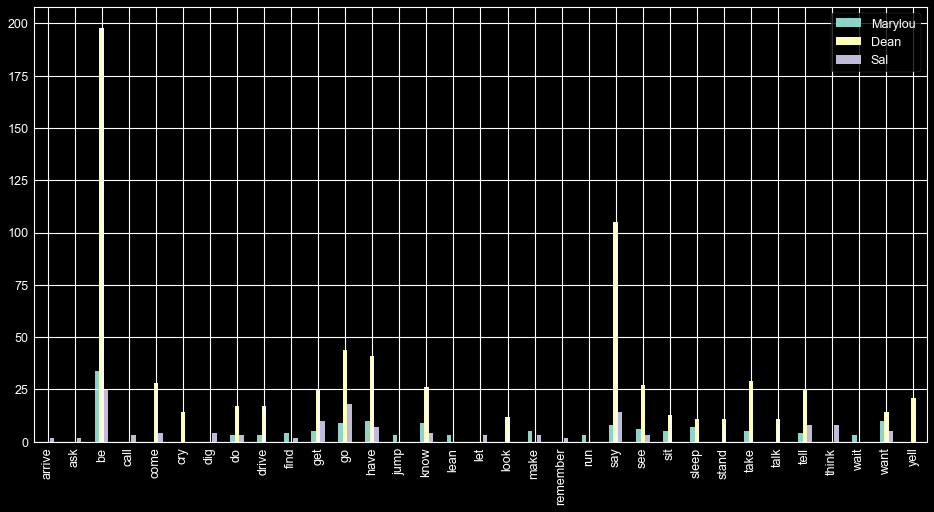

In [29]:
#Take all these counts, put into table then visualize with Pandas
def verbsToMatrix(verbCounts):
    return pd.Series({t[0]: t[1] for t in verbCounts})

verbsDF = pd.DataFrame({'Marylou': verbsToMatrix(marylouVerbs), 
                        'Dean': verbsToMatrix(deanVerbs), 
                        'Sal': verbsToMatrix(salVerbs)}).fillna(0)
verbsDF.plot(kind='bar', figsize=(16,8))

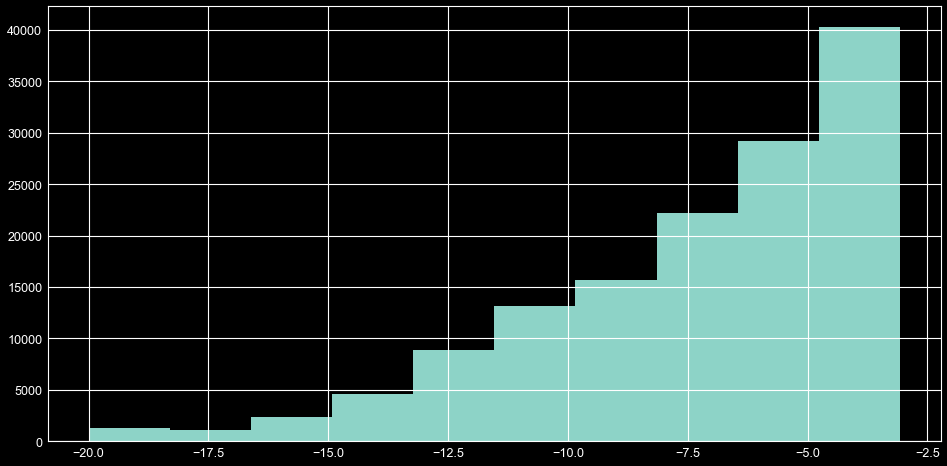

In [30]:
probabilities = [word.prob for word in kerouac]
pd.Series(probabilities).hist()

In [31]:
list(set([word.string.strip().lower() for word in kerouac if word.prob < -19]))[:20]

["everything'll",
 'impossi',
 'suitcoat',
 'rangelands',
 'intellectuals"-chad',
 'radiancies',
 'what|',
 'cottonfields',
 'legree',
 'pukish',
 'mourned-"o',
 'ashcan',
 'glooms',
 'lawtell',
 'snakejuice',
 'mehico',
 'sonumbitch',
 'thirteen-',
 'workplans',
 'box?-the']

In [32]:
Counter([word.string.strip().lower()
    for word in kerouac
    if word.prob < -19.5]).most_common(20)

[('marylou', 136),
 ('cop', 31),
 ('ponzo', 16),
 ('sabinal', 12),
 ('gregoria', 11),
 ('number', 9),
 ('boncoeur', 9),
 ("'cause", 7),
 ('lessgo', 6),
 ('part', 5),
 ('boncceur', 5),
 ('whooee', 5),
 ('pisscall', 5),
 ('fellahin', 5),
 ('jamson', 5),
 ('hyaw', 4),
 ('tinsmith', 4),
 ('dostioffski', 4),
 ('mextown', 4),
 ('heffelfinger', 4)]

In [33]:
Counter([word.string.strip().lower()
        for word in stoker
        if word.prob < -19.5
        and word.is_alpha
        and word.pos_ != 'PROPN']).most_common(20)

[('number', 21),
 ('agent', 13),
 ('mark', 10),
 ('calèche', 7),
 ('stertorous', 7),
 ('bloofer', 7),
 ('leiter', 6),
 ('isself', 5),
 ('masel', 4),
 ('steans', 4),
 ('zoöphagous', 4),
 ('anæmic', 4),
 ('arsk', 4),
 ('animiles', 4),
 ('steersman', 3),
 ('champed', 3),
 ('breakfasted', 2),
 ('boyar', 2),
 ('embrasure', 2),
 ('aërial', 2)]

In [34]:
kerouacNouns = [word for word in kerouac if word.pos_.startswith('N')][:150]

In [35]:
kerouacNounVecs = [word.vector for word in kerouacNouns]
kerouacNounLabels = [word.string.strip() for word in kerouacNouns]

In [36]:
kerouacNounVecs[0].shape

(300,)

In [37]:
lsa = TruncatedSVD(n_components=2)
lsaOut = lsa.fit_transform(kerouacNounVecs)

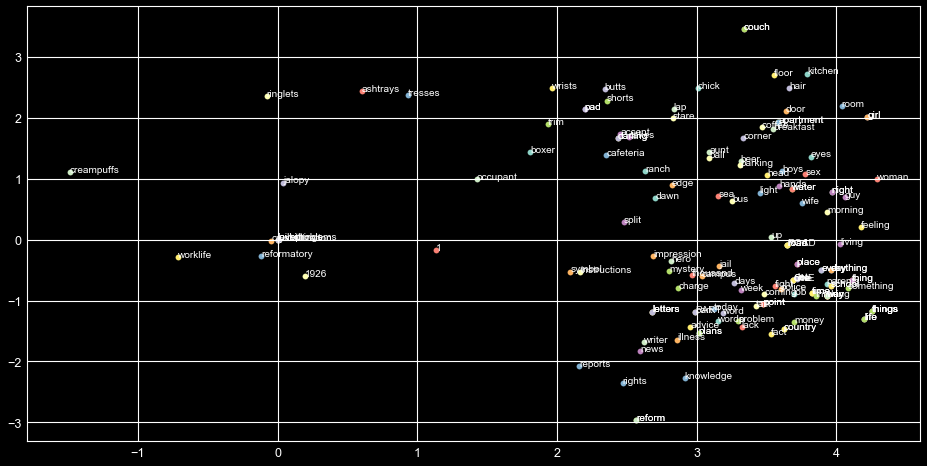

In [38]:
xs, ys = lsaOut[:,0], lsaOut[:,1]
for i in range(len(xs)):
    plt.scatter(xs[i], ys[i])
    plt.annotate(kerouacNounLabels[i], (xs[i], ys[i]))

In [46]:
kerouacTokens = word_tokenize(kerouac_raw)

In [47]:
len(kerouacTokens)

134743

In [48]:
kerouacPOS = pos_tag(kerouacTokens)

In [49]:
kerouacPOS[:30]

[('ON', 'IN'),
 ('THE', 'NNP'),
 ('ROAD', 'NNP'),
 ('PART', 'NNP'),
 ('ONE', 'NNP'),
 ('1', 'CD'),
 ('I', 'PRP'),
 ('first', 'RB'),
 ('met', 'VBD'),
 ('Dean', 'NNP'),
 ('not', 'RB'),
 ('long', 'RB'),
 ('after', 'IN'),
 ('my', 'PRP$'),
 ('wife', 'NN'),
 ('and', 'CC'),
 ('I', 'PRP'),
 ('split', 'VBP'),
 ('up', 'RB'),
 ('.', '.'),
 ('I', 'PRP'),
 ('had', 'VBD'),
 ('just', 'RB'),
 ('gotten', 'VBN'),
 ('over', 'RP'),
 ('a', 'DT'),
 ('serious', 'JJ'),
 ('illness', 'NN'),
 ('that', 'IN'),
 ('I', 'PRP')]

In [70]:
words = [pair[0] for pair in kerouacPOS]
pos = [pair[1] for pair in kerouacPOS]

In [71]:
pos[:10]

['IN', 'NNP', 'NNP', 'NNP', 'NNP', 'CD', 'PRP', 'RB', 'VBD', 'NNP']

In [72]:
Counter(pos).most_common(30)

[('NN', 16246),
 ('IN', 13266),
 ('DT', 11401),
 ('PRP', 10944),
 ('VBD', 10482),
 ('.', 7798),
 ('JJ', 7286),
 ('NNP', 7154),
 (',', 6422),
 ('RB', 6078),
 ('CC', 5610),
 ('NNS', 4691),
 ('VB', 4072),
 ('TO', 3032),
 ('VBG', 2682),
 ('PRP$', 2508),
 ('VBP', 1760),
 ('VBN', 1724),
 ("''", 1629),
 ('``', 1538),
 ('RP', 1103),
 ('MD', 1099),
 ('VBZ', 1026),
 (':', 937),
 ('CD', 745),
 ('WRB', 678),
 ('WP', 668),
 ('POS', 476),
 ('WDT', 338),
 ('EX', 275)]

In [73]:
def getAdj(taggedText):
    adjectives = []
    for pair in taggedText:
        word = pair[0]
        pos = pair[1]
        if pos == 'JJ':
            adjectives.append(word)
        return adjectives

In [80]:
kerouacAdj = getAdj(kerouacPOS)

In [81]:
Counter(kerouacAdj).most_common(20)

[]

In [76]:
len(kerouacPOS)

134743

In [77]:
print(kerouacAdj)

[]


In [78]:
Counter(kerouacAdj).most_common()

[]

In [79]:
kerouacAdj = getAdj(kerouacPOS)
Counter(kerouacAdj).most_common(20)

[]